In [1]:
from binance import Client, ThreadedWebsocketManager, ThreadedDepthCacheManager
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
import mplfinance as mpf
import yfinance as yf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import datetime as dt
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV, cross_validate, RandomizedSearchCV, validation_curve
import warnings
warnings.filterwarnings("ignore")

### Get Data From Binance

In [2]:
apikey = 'WpB8P3JSjNptV15Bq7nFLNld8kLHcwfkt0uc4NFoDGy25Y2wNwuODK7XQXQ176KA'
secret = 'MTgKRCyap8HSZtmHYxXEBDAq9wJ42xs36GPjZA8ydy2cgWIYKGhzWriOWxMxZF4S'

# AUTHENTICATION
client = Client(apikey, secret)

tickers = client.get_all_tickers()
df_tickers = pd.DataFrame(tickers)
df_tickers.set_index('symbol', inplace=True)
df_tickers.head()

### DEPTH
depth = client.get_order_book(symbol='BTCUSDT')
depth_df = pd.DataFrame(depth['asks'])
depth_df.columns = ['Price', 'Volume']
depth_df.head()

### GET HISTORICAL DATA
historical = client.get_historical_klines('BTCUSDT', Client.KLINE_INTERVAL_1DAY, '1 Jan 2011', end_str="2022-11-25")
hist_df = pd.DataFrame(historical)
hist_df.columns = ['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close Time', 'Quote Asset Volume',
                   'Number of Trades', 'TB Base Volume', 'TB Quote Volume', 'Ignore']

hist_df['Open Time'] = pd.to_datetime(hist_df['Open Time'] / 1000, unit='s')
hist_df['Close Time'] = pd.to_datetime(hist_df['Close Time'] / 1000, unit='s')
numeric_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Quote Asset Volume', 'TB Base Volume', 'TB Quote Volume']
hist_df[numeric_columns] = hist_df[numeric_columns].apply(pd.to_numeric, axis=1)

hist_df.tail()

,Open Time,Open,High,Low,Close,Volume,Close Time,Quote Asset Volume,Number of Trades,TB Base Volume,TB Quote Volume,Ignore
1922,2022-11-21,16279.50,16319.00,15476.00,15781.29,324096.997753,2022-11-21 23:59:59.999000064,5.188798e+09,7440871,159995.46460,2.561914e+09,0
1923,2022-11-22,15781.29,16315.00,15616.63,16226.94,239548.066230,2022-11-22 23:59:59.999000064,3.823613e+09,6276097,119384.47075,1.905917e+09,0
1924,2022-11-23,16227.96,16706.00,16160.20,16603.11,264927.704080,2022-11-23 23:59:59.999000064,4.368043e+09,6260616,132804.37627,2.189676e+09,0
1925,2022-11-24,16603.11,16812.63,16458.05,16598.95,206565.923460,2022-11-24 23:59:59.999000064,3.431724e+09,5031851,103203.31930,1.714661e+09,0
1926,2022-11-25,16599.55,16666.00,16342.81,16522.14,182089.495330,2022-11-25 23:59:59.999000064,3.003553e+09,4396465,90187.55597,1.487719e+09,0


### Visualization

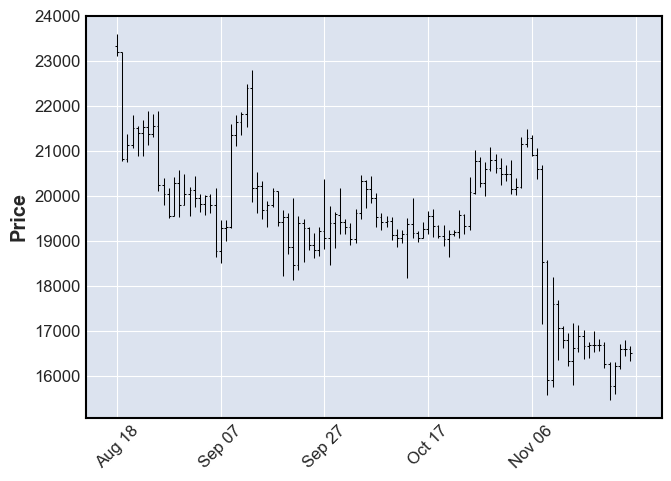

In [3]:
mpf.plot(hist_df.set_index('Close Time').tail(100))

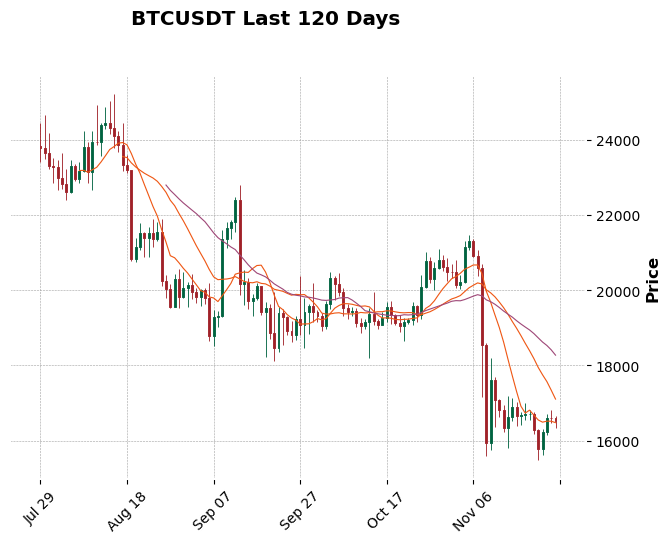

In [4]:
mpf.plot(hist_df.set_index('Close Time').tail(120),
         type='candle', style='charles',
         volume=False,
         title='BTCUSDT Last 120 Days',
         mav=(10, 20, 30))

In [5]:
df_bin = hist_df.copy()
df_bin.drop(["Close Time", "Ignore", "Open", "Close", "Low", "High"], axis=1, inplace=True)
df_bin.rename(columns={"Open Time": "Close Time", "Volume": "Binance_Volume"}, inplace=True)
df_bin.head()

,Close Time,Binance_Volume,Quote Asset Volume,Number of Trades,TB Base Volume,TB Quote Volume
0,2017-08-17,795.150377,3.454770e+06,3427,616.248541,2.678216e+06
1,2017-08-18,1199.888264,5.086958e+06,5233,972.868710,4.129123e+06
2,2017-08-19,381.309763,1.549484e+06,2153,274.336042,1.118002e+06
3,2017-08-20,467.083022,1.930364e+06,2321,376.795947,1.557401e+06
4,2017-08-21,691.743060,2.797232e+06,3972,557.356107,2.255663e+06


### Get Data From Yahoo Finance

In [6]:
yahoo = yf.download("BTC-USD", end="2022-11-25")
yahoo.reset_index("Date", inplace=True)
yahoo.rename(columns={"Date": "Close Time"}, inplace=True)

[*********************100%***********************]  1 of 1 completed


In [7]:
df = pd.merge(yahoo, df_bin, on="Close Time", how="outer")
df.sort_values("Close Time", inplace=True)
df.head()

,Close Time,Open,High,Low,Close,Adj Close,Volume,Binance_Volume,Quote Asset Volume,Number of Trades,TB Base Volume,TB Quote Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0,NaN,NaN,NaN,NaN,NaN
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0,NaN,NaN,NaN,NaN,NaN
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0,NaN,NaN,NaN,NaN,NaN
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0,NaN,NaN,NaN,NaN,NaN
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0,NaN,NaN,NaN,NaN,NaN


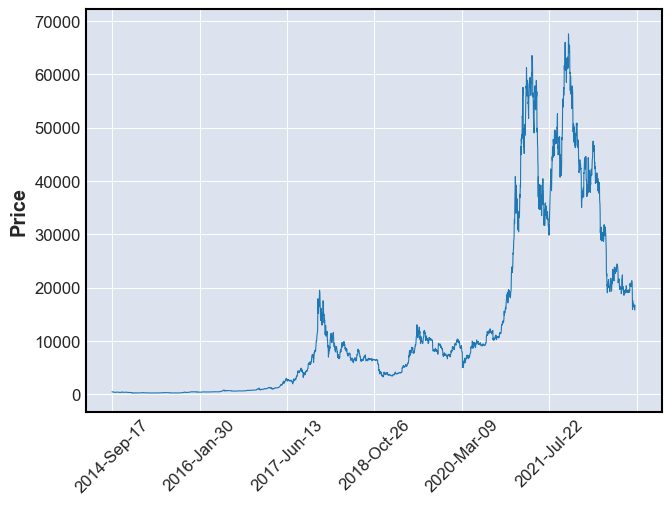

In [8]:
mpf.plot(df.set_index('Close Time'), type="line")

4 algorithm will be used:
1. TES (Triple Exponential Smoothing)
2. SARIMA
3. LGBM
4. LSTM

TES and SARIMA are the special algorithms for Time Series. The only need is to give the "Close Time", and there will catch trend, seasonality and cycle. Since BTC is affected too many events, I don't expect that these works well, but I will try.

## TES & SARIMA

In [9]:
# TRAIN-TEST SPLIT - ONE VARIABLE
df_one = df[["Close", "Close Time"]].set_index("Close Time").squeeze()
df_one = df_one["2020-11-01":]  # ignore the beginning since there are outliers
df_one.dropna(inplace=True)
train_one = df_one[:int(len(df_one) * 0.8)]
test_one = df_one[int(len(df_one) * 0.8):]

Firstly, check stationary, trend, seasonality and cycle for choosing additive or multiplicative.

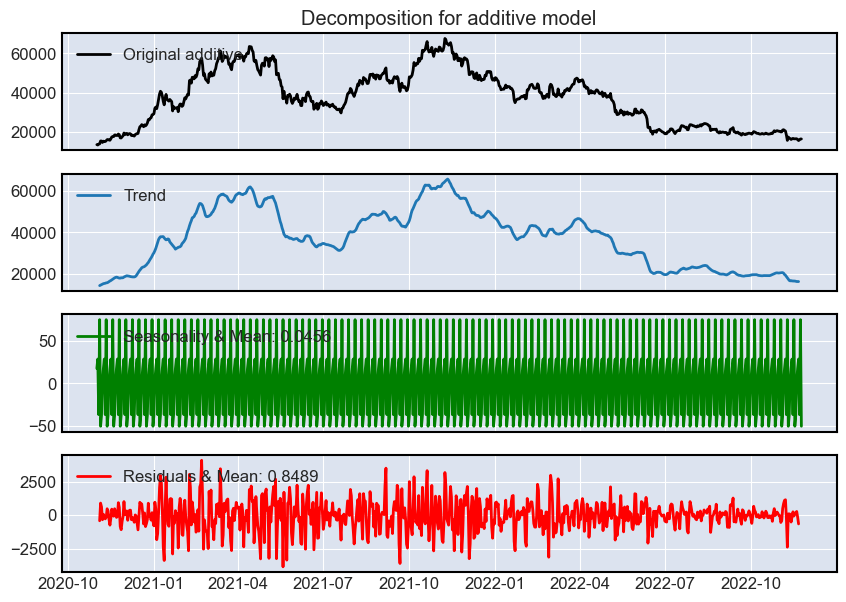

In [10]:
def ts_decompose(y, model="additive"):
    result = seasonal_decompose(y, model=model)
    fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
    fig.set_figheight(7)
    fig.set_figwidth(10)

    axes[0].set_title("Decomposition for " + model + " model")
    axes[0].plot(y, 'k', label='Original ' + model)
    axes[0].legend(loc='upper left')

    axes[1].plot(result.trend, label='Trend')
    axes[1].legend(loc='upper left')

    axes[2].plot(result.seasonal, 'g', label='Seasonality & Mean: ' + str(round(result.seasonal.mean(), 4)))
    axes[2].legend(loc='upper left')

    axes[3].plot(result.resid, 'r', label='Residuals & Mean: ' + str(round(result.resid.mean(), 4)))
    axes[3].legend(loc='upper left')
    plt.show(block=True)


ts_decompose(df_one)

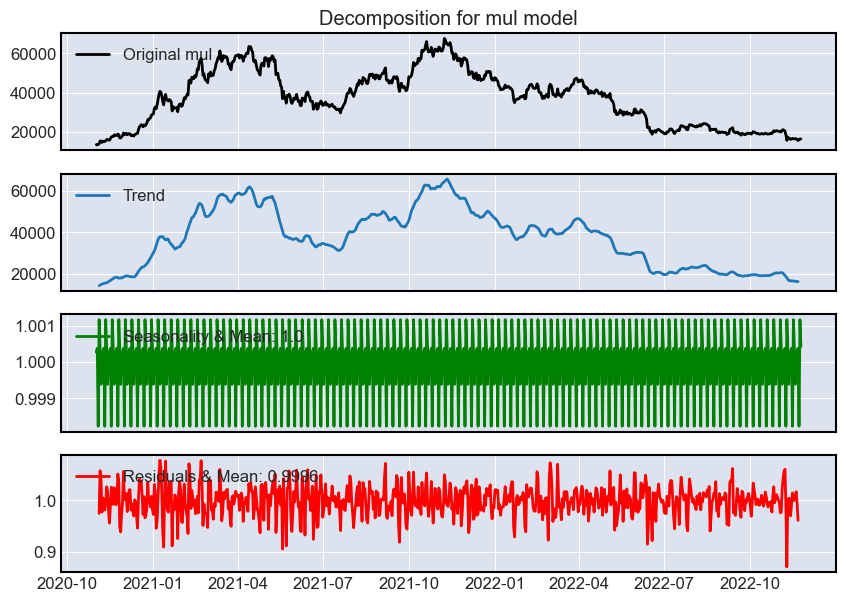

In [11]:
ts_decompose(df_one, model="mul")

We will use additive model since Residuals reflected better.

## TES (Triple Exponential Smoothing)

In [12]:
def tes_optimizer(train, test, abgs, step=48, model="mul"):
    best_alpha, best_beta, best_gamma, best_seas_per, best_mae = None, None, None, None, float("inf")
    for comb in abgs:
        try:
            tes_model = ExponentialSmoothing(train, trend=model, seasonal=model, seasonal_periods=comb[3]). \
                fit(smoothing_level=comb[0], smoothing_slope=comb[1], smoothing_seasonal=comb[2])
            y_pred = tes_model.forecast(step)
            mae = mean_absolute_error(test, y_pred)
            if mae < best_mae:
                best_alpha, best_beta, best_gamma, best_seas_per, best_mae = comb[0], comb[1], comb[2], comb[3], mae
            print([round(comb[0], 3), round(comb[1], 3), round(comb[2], 3), round(comb[3], 3), round(mae, 3)])
        except:
            continue

    print("best_alpha:", round(best_alpha, 3), "best_beta:", round(best_beta, 3), "best_seas_per:",
          round(best_seas_per, 3),
          "best_gamma:", round(best_gamma, 3), "best_mae:", round(best_mae, 4))

    return best_alpha, best_beta, best_gamma, best_seas_per, best_mae


alphas = betas = gammas = np.arange(0.01, 0.11, 0.01)
seas_per = [7, 30]
abgs = list(itertools.product(alphas, betas, gammas, seas_per))

best_alpha, best_beta, best_gamma, best_seas_per, best_mae = tes_optimizer(train_one, test_one, abgs,
                                                                           step=len(test_one))

[0.01, 0.01, 0.01, 7, 2803.63]
[0.01, 0.01, 0.01, 30, 3413.035]
[0.01, 0.01, 0.02, 7, 3742.576]
[0.01, 0.01, 0.02, 30, 3582.419]
[0.01, 0.01, 0.03, 7, 4725.093]
[0.01, 0.01, 0.03, 30, 3760.802]
[0.01, 0.01, 0.04, 7, 5692.637]
[0.01, 0.01, 0.04, 30, 3955.203]
[0.01, 0.01, 0.05, 7, 6562.179]
[0.01, 0.01, 0.05, 30, 4153.884]
[0.01, 0.01, 0.06, 7, 7344.943]
[0.01, 0.01, 0.06, 30, 4352.266]
[0.01, 0.01, 0.07, 7, 8054.477]
[0.01, 0.01, 0.07, 30, 4549.189]
[0.01, 0.01, 0.08, 7, 8701.964]
[0.01, 0.01, 0.08, 30, 4740.14]
[0.01, 0.01, 0.09, 7, 9296.414]
[0.01, 0.01, 0.09, 30, 4924.582]
[0.01, 0.01, 0.1, 7, 9845.006]
[0.01, 0.01, 0.1, 30, 5101.323]
[0.01, 0.02, 0.01, 7, 3300.575]
[0.01, 0.02, 0.01, 30, 3359.871]
[0.01, 0.02, 0.02, 7, 2888.097]
[0.01, 0.02, 0.02, 30, 5399.991]
[0.01, 0.02, 0.03, 7, 2617.087]
[0.01, 0.02, 0.03, 30, 3136.171]
[0.01, 0.02, 0.04, 7, 2444.194]
[0.01, 0.02, 0.04, 30, 3039.237]
[0.01, 0.02, 0.05, 7, 2339.292]
[0.01, 0.02, 0.05, 30, 2951.297]
[0.01, 0.02, 0.06, 7, 2273.95

In [13]:
print(f"Best Alpha: {best_alpha}\nBest Beta: {best_beta}\nBest Gamma: {best_gamma}"
      f"\nBest Seasonality Period: {best_seas_per}\nBest MAE: {best_mae}")

Best Alpha: 0.03
Best Beta: 0.01
Best Gamma: 0.09999999999999999
Best Seasonality Period: 7
Best MAE: 1529.310290865511


In [14]:
# Final Model
final_tes_model = ExponentialSmoothing(train_one, trend="add", seasonal="add", seasonal_periods=best_seas_per). \
    fit(smoothing_level=best_alpha, smoothing_trend=best_beta, smoothing_seasonal=best_gamma)

In [15]:
def plot_btc(train, test, y_pred, title):
    mae = mean_absolute_error(test, y_pred)
    train.plot(legend=True, label="TRAIN", title=f"{title}, MAE: {round(mae, 2)}")
    test.plot(legend=True, label="TEST", figsize=(10, 6))
    y_pred.plot(legend=True, label="PREDICTION")
    plt.show()

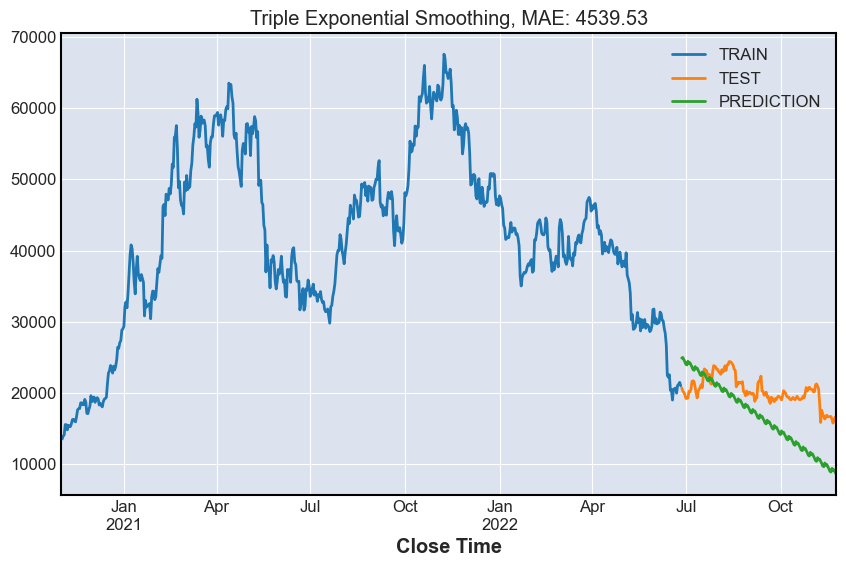

In [16]:
y_pred = final_tes_model.forecast(len(test_one))
plot_btc(train_one, test_one, y_pred, "Triple Exponential Smoothing")

## SARIMA

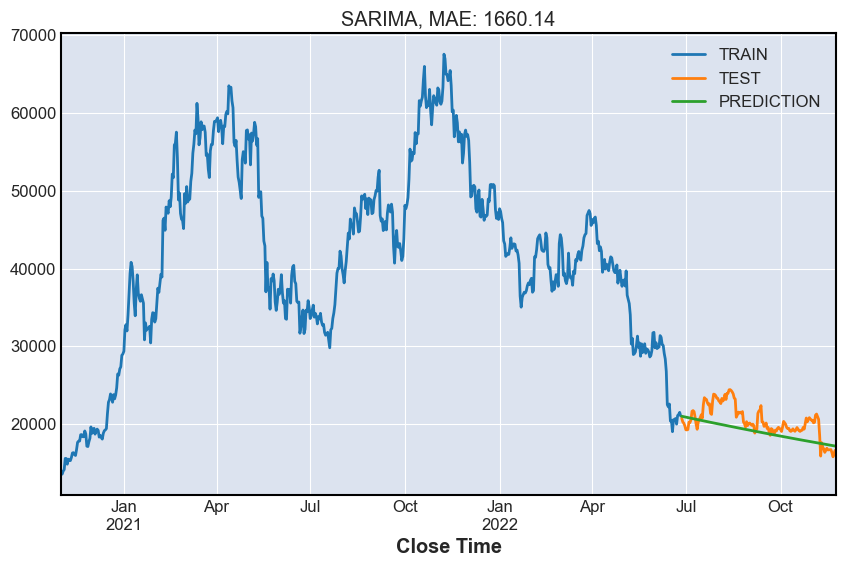

In [17]:
model = SARIMAX(train_one)
sarima_model = model.fit(disp=0)
y_pred_test = sarima_model.get_forecast(steps=len(test_one))
y_pred = y_pred_test.predicted_mean
y_pred = pd.Series(y_pred, index=test_one.index)
plot_btc(train_one, test_one, y_pred, "SARIMA")

In [18]:
# Hyperparameter Optimization
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

def sarima_optimizer_mae(train, test, pdq, seasonal_pdq):
    best_mae, best_order, best_seasonal_order = float("inf"), None, None
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                model = SARIMAX(train, order=param, seasonal_order=param_seasonal)
                sarima_model = model.fit(disp=0)
                y_pred_test = sarima_model.get_forecast(steps=len(test))
                y_pred = y_pred_test.predicted_mean
                mae = mean_absolute_error(test, y_pred)
                if mae < best_mae:
                    best_mae, best_order, best_seasonal_order = mae, param, param_seasonal
                print('SARIMA{}x{}12 - MAE:{}'.format(param, param_seasonal, mae))
            except:
                continue
    print('SARIMA{}x{}12 - MAE:{}'.format(best_order, best_seasonal_order, best_mae))
    return best_order, best_seasonal_order

In [19]:
best_order, best_seasonal_order = sarima_optimizer_mae(train_one, test_one, pdq, seasonal_pdq)

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - MAE:20357.936879139073
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - MAE:19918.357022003387
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - MAE:1717.7655085885763
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - MAE:1709.6141333605929
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - MAE:2004.1144846133395
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - MAE:1994.9296124364753
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - MAE:1707.7698667494615
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - MAE:3000.5442869910958
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - MAE:20302.095309203316
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - MAE:19826.743330054604
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - MAE:1645.967930304189
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - MAE:1927.7471634595252
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - MAE:2549.5579361205077
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - MAE:2566.1706445877376
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - MAE:1997.2702683375317
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - MAE:1697.3719239432571
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - MAE:1717.3141685637418
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 

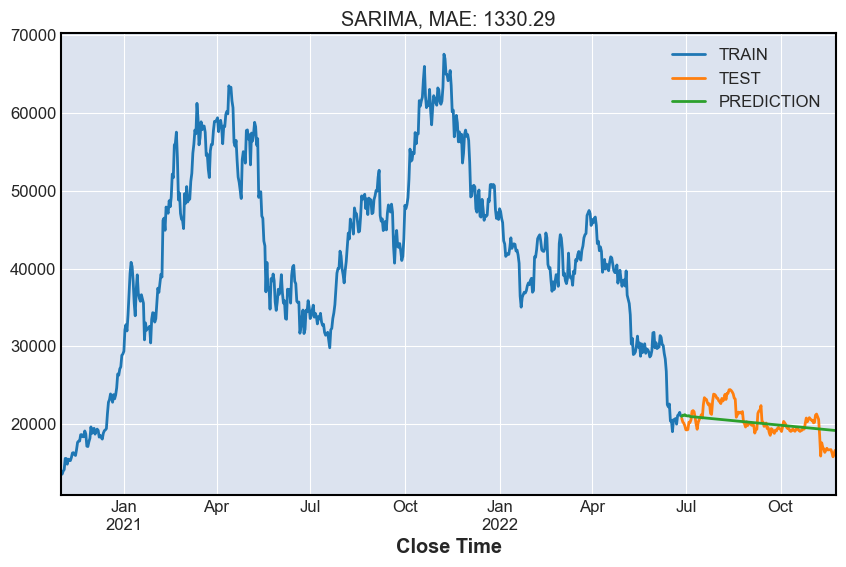

In [20]:
# Final Model
model = SARIMAX(train_one, order=best_order, seasonal_order=best_seasonal_order)
sarima_final_model = model.fit(disp=0)
y_pred_test = sarima_final_model.get_forecast(steps=len(test_one))
y_pred = y_pred_test.predicted_mean
y_pred = pd.Series(y_pred, index=test_one.index)
plot_btc(train_one, test_one, y_pred, "SARIMA")

In [21]:
# Forecast for 7 days
feature_sarima_pred = sarima_final_model.get_forecast(steps=7).predicted_mean
feature_sarima_pred

2022-06-27    20985.909213
2022-06-28    21132.660180
2022-06-29    21111.613127
2022-06-30    21204.138141
2022-07-01    21076.746990
2022-07-02    21058.932590
2022-07-03    21036.360634
Freq: D, Name: predicted_mean, dtype: float64

**Eventhough SARIMA is better than TES, both TES and SARIMA did not work well as I expected. They are Time Series Algorithms but BTC does not a perfect fit for these. Therefore, I will try LGBM and LSTM.**

## LGBM

Firstly, we have to create features for data.

In [22]:
# Date Featues
def create_date_features(df):
    df['month'] = df["Close Time"].dt.month
    df['day_of_month'] = df["Close Time"].dt.day
    df['day_of_year'] = df["Close Time"].dt.dayofyear
    df['week_of_year'] = df["Close Time"].dt.weekofyear
    df['day_of_week'] = df["Close Time"].dt.dayofweek
    df['year'] = df["Close Time"].dt.year
    df["is_wknd"] = df["Close Time"].dt.weekday // 4
    df['is_month_start'] = df["Close Time"].dt.is_month_start.astype(int)
    df['is_month_end'] = df["Close Time"].dt.is_month_end.astype(int)
    return df


df = create_date_features(df)

### Indicators
Indicators are one of the most crucial things for stock prices and BTC. Create indicators and save this to our dataframe.

In [23]:
# Shift
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))


def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['close_lag_' + str(lag)] = dataframe["Close"].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe


df = lag_features(df, [1, 3, 7, 20, 30, 50, 100, 200])

In [24]:
# Simple Moving Average
def SMA(dataframe, windows):
    for window in windows:
        dataframe["SMA_" + str(window)] = dataframe["Close"].transform(
            lambda x: x.shift(1).rolling(window=window, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe


df = SMA(df, [7, 20, 30, 50, 100, 200])

In [25]:
# MACD
def MACD(df, n_fast, n_slow, n_smooth):
    data = df['Close']

    fastEMA = data.ewm(span=n_fast, min_periods=n_slow).mean()
    slowEMA = data.ewm(span=n_slow, min_periods=n_slow).mean()
    MACD = pd.Series(fastEMA - slowEMA, name='MACD')
    MACDsig = pd.Series(MACD.ewm(span=n_smooth, min_periods=n_smooth).mean(), name='MACDsig')
    MACDhist = pd.Series(MACD - MACDsig, name='MACDhist')
    df = df.join(MACD)
    df = df.join(MACDsig)
    df = df.join(MACDhist)

    return df


df = MACD(df, 12, 26, 9)

In [26]:
# Exponentially Weighted Mean
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['close_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe["Close"].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe


alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [7, 20, 30, 50, 100, 200]
df = ewm_features(df, alphas, lags)

In [27]:
# Bollinger Bands
# Middle Band: 30 Day moving average
# Upper Band: Middle Band  + 2 x 30 Day Moving Standard Deviation
# Lower Band: Middle Band  – 2 x 30 Day Moving Standard Deviation

def BBANDS(dataframe, windows):
    for window in windows:
        MA = dataframe.Close.rolling(window).mean()
        SD = dataframe.Close.rolling(window).std()
        dataframe['MiddleBand_' + str(window)] = MA
        dataframe['UpperBand_' + str(window)] = MA + (2 * SD)
        dataframe['LowerBand_' + str(window)] = MA - (2 * SD)
    return dataframe


df = BBANDS(df, [30])

In [28]:
# RSI
def rsi(close, periods=14):
    close_delta = close.diff()
    # Make two series: one for lower closes and one for higher closes
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    ma_up = up.ewm(com=periods - 1, adjust=True, min_periods=periods).mean()
    ma_down = down.ewm(com=periods - 1, adjust=True, min_periods=periods).mean()
    rsi = ma_up / ma_down
    rsi = 100 - (100 / (1 + rsi))
    return rsi

df['RSI'] = rsi(df['Close'])

In [29]:
# Money Flow Index - MFI
def gain(x):
    return ((x > 0) * x).sum()


def loss(x):
    return ((x < 0) * x).sum()


# Calculate money flow index
def mfi(high, low, close, volume, n=14):
    typical_price = (high + low + close) / 3
    money_flow = typical_price * volume
    mf_sign = np.where(typical_price > typical_price.shift(1), 1, -1)
    signed_mf = money_flow * mf_sign
    mf_avg_gain = signed_mf.rolling(n).apply(gain, raw=True)
    mf_avg_loss = signed_mf.rolling(n).apply(loss, raw=True)
    return (100 - (100 / (1 + (mf_avg_gain / abs(mf_avg_loss))))).to_numpy()


df['MFI'] = mfi(df['High'], df['Low'], df['Close'], df['Volume'], 14)

In [30]:
# Average True Range - ATR => For Volatility
def atr(high, low, close, n=14):
    tr = np.amax(np.vstack(((high - low).to_numpy(), (abs(high - close)).to_numpy(), (abs(low - close)).to_numpy())).T,
                 axis=1)
    return pd.Series(tr).rolling(n).mean().to_numpy()


df['ATR'] = atr(df['High'], df['Low'], df['Close'], 14)

In [31]:
# Force Index
def ForceIndex(dataframe, ndays):
    for day in ndays:
        dataframe["FI_" + str(day)] = dataframe['Close'].diff(day) * dataframe['Volume']
    return dataframe


df = ForceIndex(df, [7, 20, 30, 50, 100, 200])

In [32]:
# Ease of Movement
def EMV(dataframe, ndays):
    for day in ndays:
        dm = ((dataframe['High'] + dataframe['Low']) / 2) - (
                (dataframe['High'].shift(1) + dataframe['Low'].shift(1)) / 2)
        br = (dataframe['Volume'] / 100000000) / ((dataframe['High'] - dataframe['Low']))
        EMV = dm / br
        dataframe["EMV_" + str(day)] = EMV.rolling(day).mean()
    return dataframe

df = EMV(df, [7, 20, 30, 50, 100, 200])

BTC was invented for not being tied to any central bank or single administrator. After a while, With the increase of investors, it has become affected by stock markets on US. Add these on our dataframe with the help of TradingView API.

In [33]:
from tvDatafeed import TvDatafeed, Interval

username = 'techbtc'
password = 'finalbtc1'
tv = TvDatafeed(username, password)

In [34]:
def download_data(dataframe, currency_list, end):
    for currency in currency_list:
        print("Downloading starting for", currency)
        df_curr = tv.get_hist(symbol=f"{currency}", n_bars=3000)
        print("Downloading completed for", currency)
        print("------------------------------------------")
        df_curr = df_curr["close"]
        currency = currency.split(sep=":")[1]
        df_curr = df_curr["2014-09-17":end]
        df_curr = pd.DataFrame(df_curr)
        df_curr.reset_index("datetime", inplace=True)
        df_curr.rename(columns={"datetime": "Close Time", "close": f"Close_{currency.lower()}"}, inplace=True)
        df_curr["Close Time"] = df_curr["Close Time"].apply(lambda x: x.date())
        df_curr["Close Time"] = df_curr["Close Time"].astype("datetime64[ns]")
        dataframe = pd.merge(dataframe, df_curr, on="Close Time", how="left")
        dataframe.sort_values("Close Time", inplace=True)
    return dataframe

In [35]:
curr_list = ["NASDAQ:NDX", "FRED:SP500", "INDEX:DXY", "TVC:DJI", "RUSSELL:RUT",
             "NASDAQ:XAU", "NYMEX:CL1!", "XETR:DAX", "CRYPTOCAP:TOTAL2", "CRYPTOCAP:BTC.D",
             "ECONOMICS:USIRYY", "VANTAGE:GAS", "TVC:UKOIL", "ECONOMICS:USINTR", "NASDAQ:XAU"]

df = download_data(df, curr_list, end="2022-11-25")

------------------------------------------
------------------------------------------
------------------------------------------
------------------------------------------
------------------------------------------
------------------------------------------
------------------------------------------
------------------------------------------
------------------------------------------
------------------------------------------
------------------------------------------
------------------------------------------
------------------------------------------
------------------------------------------
------------------------------------------


In [36]:
def fill_values(dataframe, column, num=21):
    for i in range(num):
        dataframe[column] = dataframe[column].fillna(dataframe[column].bfill())

fill_values(df, "Close_usintr")
fill_values(df, "Close_gas")
fill_values(df, "Close_ukoil", num=10)
fill_values(df, "Close_usiryy", num=30)

In [37]:
df.shape

(2992, 101)

We don't need to use Encoder since we have no categorical feature.

Finally, we can build our LGBM model.

In [45]:
df_ = df.copy()

In [80]:
# MODEL
train = df[:int(len(df) * 0.8)]  # df => starts 2020-11-02
val = df[int(len(df) * 0.8):-1]

cols = [col for col in train.columns if col not in ['Close Time', "Close"]]

Y_train = train['Close']  # bağımlı değişken
X_train = train[cols]  # bağımsız değişkenler yukarıda seçtiklerimiz

Y_val = val['Close']
X_val = val[cols]

Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((2393,), (2393, 99), (598,), (598, 99))

In [81]:
lgbm_model = LGBMRegressor().fit(X_train, Y_train)
y_pred = lgbm_model.predict(X_val)
np.sqrt(mean_squared_error(Y_val, y_pred)) # first test error

4668.587963519425

In [97]:
# for all data
all_data = df.iloc[:-1]
y_pred = lgbm_model.predict(all_data.drop(['Close Time', "Close"], axis=1))
np.sqrt(mean_squared_error(all_data["Close"], y_pred))

2088.7634180787836

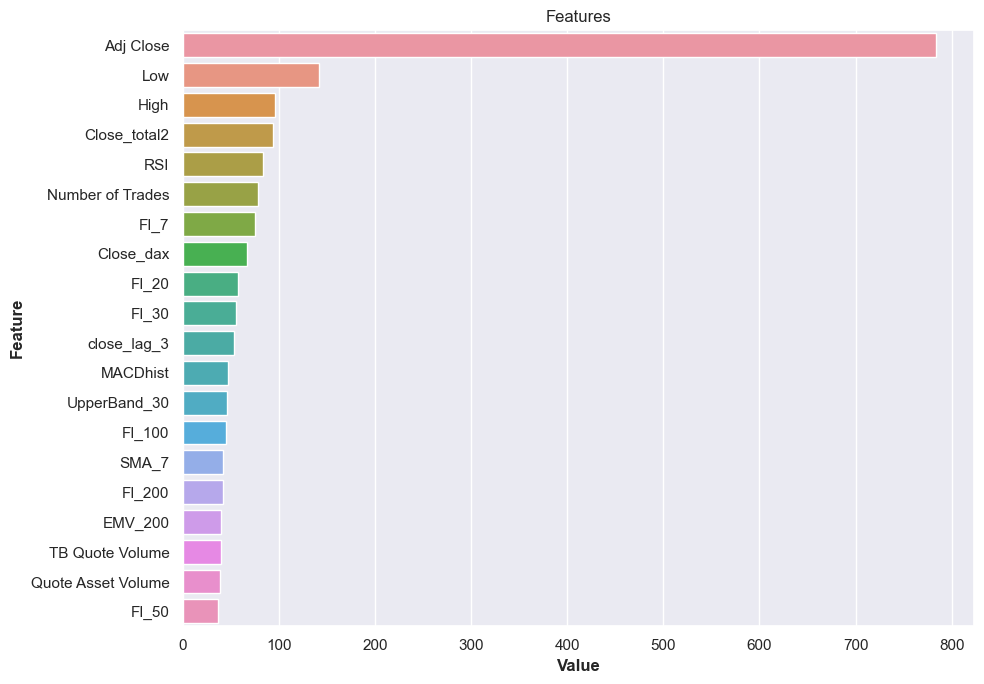

In [98]:
def plot_importance(model, features, num=len(X_train), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 7))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')
    return feature_imp


df_feat = plot_importance(lgbm_model, features=X_train, num=20)

In [103]:
# Hyperparameter optimization
lgbm_model = LGBMRegressor(random_state=17, verbosity=0, metric="mae")
lgbm_random_params = {'num_leaves': np.random.randint(1, 40, 20),
                      'feature_fraction': [0.7, 0.75, 0.8, 0.9, 1],
                      'num_boost_round': [1000, 1500, 2000, 2500, 4000, 3000, 5000],
                      'early_stopping_rounds': [40, 50, 60, 70, 100],
                      "max_depth": np.random.randint(-3, 15, 15),
                      "max_features": [1, 2, 3, 4, 5, 7, 9, "auto", "sqrt"],
                      "min_samples_split": np.random.randint(10, 50, 25),
                      "n_estimators": [int(x) for x in np.linspace(start=150, stop=500, num=40)],
                      "learning_rate": [0.01, 0.03, 0.05, 0.08, 0.1]}

lgbm_random = RandomizedSearchCV(estimator=lgbm_model,
                                 param_distributions=lgbm_random_params,
                                 n_iter=10,
                                 cv=3,
                                 verbose=False,
                                 random_state=42,
                                 n_jobs=-1)
lgbm_random.fit(X_train, Y_train, eval_set=(X_val, Y_val))
final_params = lgbm_random.best_params_

lgbm_model.set_params(**lgbm_random.best_params_, random_state=17). \
    fit(X_train, Y_train, eval_set=(X_val, Y_val))

/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_rou

[131]	valid_0's l1: 6570.48
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[132]	valid_0's l1: 6483.39
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[133]	valid_0's l1: 6414.67
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[134]	valid_0's l1: 6343.12
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[135]	valid_0's l1: 6306.04
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[136]	valid_0's l1: 6223.52
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[137]	valid_0's l1: 6147.27
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[138]	valid_0's l1: 6085.1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[139]	valid_0's l1: 6022.98
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[140]	valid_0's l1: 5962.24
[LightGBM] [Warning] No further splits with po

/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[430]	valid_0's l1: 23036.7
[431]	valid_0's l1: 23034.7
[432]	valid_0's l1: 23032.7
[433]	valid_0's l1: 23031.2
[434]	valid_0's l1: 23029.9
[435]	valid_0's l1: 23028.6
[436]	valid_0's l1: 23026.5
[437]	valid_0's l1: 23025.2
[438]	valid_0's l1: 23023.3
[439]	valid_0's l1: 23022
[440]	valid_0's l1: 23020.8
[441]	valid_0's l1: 23019.5
[442]	valid_0's l1: 23017.8
[443]	valid_0's l1: 23016.5
[444]	valid_0's l1: 23014.9
[445]	valid_0's l1: 23013.8
[446]	valid_0's l1: 23011.9
[447]	valid_0's l1: 23011
[448]	valid_0's l1: 23009.8
[449]	valid_0's l1: 23008.2
[450]	valid_0's l1: 23007
[451]	valid_0's l1: 23005
[452]	valid_0's l1: 23003.1
[453]	valid_0's l1: 23001.2
[454]	valid_0's l1: 23000.1
[455]	valid_0's l1: 22998.9
[456]	valid_0's l1: 22997.4
[457]	valid_0's l1: 22996.3
[458]	valid_0's l1: 22994.5
[459]	valid_0's l1: 22992.6
[460]	valid_0's l1: 22990.8
[461]	valid_0's l1: 22989
[462]	valid_0's l1: 22987.5
[463]	valid_0's l1: 22985
[464]	valid_0's l1: 22983.4
[465]	valid_0's l1: 22982.7
[466

/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[518]	valid_0's l1: 22890.8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[519]	valid_0's l1: 22889.9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[520]	valid_0's l1: 22888.9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[521]	valid_0's l1: 22888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[522]	valid_0's l1: 22887.1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[523]	valid_0's l1: 22885.9
[524]	valid_0's l1: 22885.4
[525]	valid_0's l1: 22881.3
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[526]	valid_0's l1: 22880.4
[527]	valid_0's l1: 22876.6
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[528]	valid_0's l1: 22875.6
[529]	valid_0's l1: 22871.5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[530]	valid_0's l1: 22870.5
[LightGBM] [Warning] No further splits

/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[292]	valid_0's l1: 22943.8
[293]	valid_0's l1: 22943.6
[294]	valid_0's l1: 22940.6
[295]	valid_0's l1: 22940
[296]	valid_0's l1: 22939.4
[297]	valid_0's l1: 22936.4
[298]	valid_0's l1: 22938.6
[299]	valid_0's l1: 22935.5
[300]	valid_0's l1: 22934.8
[301]	valid_0's l1: 22934.3
[302]	valid_0's l1: 22931.6
[303]	valid_0's l1: 22932
[304]	valid_0's l1: 22934.4
[305]	valid_0's l1: 22931.4
[306]	valid_0's l1: 22930.9
[307]	valid_0's l1: 22927.8
[308]	valid_0's l1: 22930
[309]	valid_0's l1: 22926.9
[310]	valid_0's l1: 22924
[311]	valid_0's l1: 22924.2
[312]	valid_0's l1: 22926.6
[313]	valid_0's l1: 22928.8
[314]	valid_0's l1: 22925.8
[315]	valid_0's l1: 22927.9
[316]	valid_0's l1: 22927.4
[317]	valid_0's l1: 22924.5
[318]	valid_0's l1: 22921.7
[319]	valid_0's l1: 22920.9
[320]	valid_0's l1: 22922
[321]	valid_0's l1: 22919.5
[322]	valid_0's l1: 22916.8
[323]	valid_0's l1: 22919.3
[324]	valid_0's l1: 22921.4
[325]	valid_0's l1: 22918.7
[326]	valid_0's l1: 22918.1
[327]	valid_0's l1: 22917.7
[3

/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[713]	valid_0's l1: 23021.2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[714]	valid_0's l1: 23022.1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[715]	valid_0's l1: 23022.1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[716]	valid_0's l1: 23021.2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[717]	valid_0's l1: 23022.2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[718]	valid_0's l1: 23021.3
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[719]	valid_0's l1: 23020.6
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[720]	valid_0's l1: 23020
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[721]	valid_0's l1: 23021
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7

/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[114]	valid_0's l1: 9399.07
[115]	valid_0's l1: 9319.77
[116]	valid_0's l1: 9230.01
[117]	valid_0's l1: 9133.39
[118]	valid_0's l1: 9053.95
[119]	valid_0's l1: 8976.94
[120]	valid_0's l1: 8896.86
[121]	valid_0's l1: 8818.2
[122]	valid_0's l1: 8726.4
[123]	valid_0's l1: 8601.52
[124]	valid_0's l1: 8518.43
[125]	valid_0's l1: 8428.57
[126]	valid_0's l1: 8356.19
[127]	valid_0's l1: 8284.13
[128]	valid_0's l1: 8197.85
[129]	valid_0's l1: 8112.59
[130]	valid_0's l1: 8027.4
[131]	valid_0's l1: 7960.08
[132]	valid_0's l1: 7839.91
[133]	valid_0's l1: 7762.2
[134]	valid_0's l1: 7695.02
[135]	valid_0's l1: 7614.52
[136]	valid_0's l1: 7544.67
[137]	valid_0's l1: 7437.54
[138]	valid_0's l1: 7358.92
[139]	valid_0's l1: 7336.69
[140]	valid_0's l1: 7275.78
[141]	valid_0's l1: 7206.93
[142]	valid_0's l1: 7132.1
[143]	valid_0's l1: 7072.35
[144]	valid_0's l1: 7010.65
[145]	valid_0's l1: 6938.04
[146]	valid_0's l1: 6880.91
[147]	valid_0's l1: 6865.49
[148]	valid_0's l1: 6795.09
[149]	valid_0's l1: 6725.

/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1267]	valid_0's l1: 22614
[1268]	valid_0's l1: 22613.1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1269]	valid_0's l1: 22613.3
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1270]	valid_0's l1: 22612.7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1271]	valid_0's l1: 22613
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1272]	valid_0's l1: 22612.3
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1273]	valid_0's l1: 22612.2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1274]	valid_0's l1: 22611.6
[1275]	valid_0's l1: 22611.5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1276]	valid_0's l1: 22610.9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1277]	valid_0's l1: 22611.1
[LightGBM]

/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1649]	valid_0's l1: 22556.3
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1650]	valid_0's l1: 22556.3
[1651]	valid_0's l1: 22556.5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1652]	valid_0's l1: 22556.1
[1653]	valid_0's l1: 22556.2
[1654]	valid_0's l1: 22555.4
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1655]	valid_0's l1: 22554.9
[1656]	valid_0's l1: 22554.9
[1657]	valid_0's l1: 22554.8
[1658]	valid_0's l1: 22554.8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1659]	valid_0's l1: 22555.2
[1660]	valid_0's l1: 22555.2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1661]	valid_0's l1: 22554.7
[1662]	valid_0's l1: 22553.6
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1663]	valid_0's l1: 22553.2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1664]	valid_0's l1: 22553.3
[LightGBM] 

/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[79]	valid_0's l1: 3234.79
[80]	valid_0's l1: 3232.17
[81]	valid_0's l1: 3230.23
[82]	valid_0's l1: 3235.13
[83]	valid_0's l1: 3232.13
[84]	valid_0's l1: 3236.4
[85]	valid_0's l1: 3235.2
[86]	valid_0's l1: 3235.17
[87]	valid_0's l1: 3238.94
[88]	valid_0's l1: 3238.84
[89]	valid_0's l1: 3238.94
[90]	valid_0's l1: 3242.36
[91]	valid_0's l1: 3239.26
[92]	valid_0's l1: 3238.41
[93]	valid_0's l1: 3235.86
[94]	valid_0's l1: 3239.5
[95]	valid_0's l1: 3237.3
[96]	valid_0's l1: 3240.44
[97]	valid_0's l1: 3236.81
[98]	valid_0's l1: 3240.37
[99]	valid_0's l1: 3240.07
[100]	valid_0's l1: 3236.66
[101]	valid_0's l1: 3239.15
[102]	valid_0's l1: 3238.57
[103]	valid_0's l1: 3237.84
[104]	valid_0's l1: 3236.04
[105]	valid_0's l1: 3235.52
[106]	valid_0's l1: 3235.24
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] num_iterations is set=2500, num_boost_round=2500 will be ignored. Current value: num_iterations=2500
[LightGB

LGBMRegressor(early_stopping_rounds=50, feature_fraction=0.9,
              learning_rate=0.03, max_depth=11, max_features=3, metric='mae',
              min_samples_split=44, n_estimators=455, num_boost_round=2000,
              num_leaves=35, random_state=17, verbosity=0)

In [105]:
lgbm_random.best_params_

{'num_leaves': 35,
 'num_boost_round': 2000,
 'n_estimators': 455,
 'min_samples_split': 44,
 'max_features': 3,
 'max_depth': 11,
 'learning_rate': 0.03,
 'feature_fraction': 0.9,
 'early_stopping_rounds': 50}

In [104]:
y_pred = lgbm_model.predict(X_val)
np.sqrt(mean_squared_error(Y_val, y_pred))

4629.225120341208

In [106]:
y_pred = lgbm_model.predict(all_data.drop(['Close Time', "Close"], axis=1))
np.sqrt(mean_squared_error(all_data["Close"], y_pred))

2070.954933588818

Model is slightly improved.

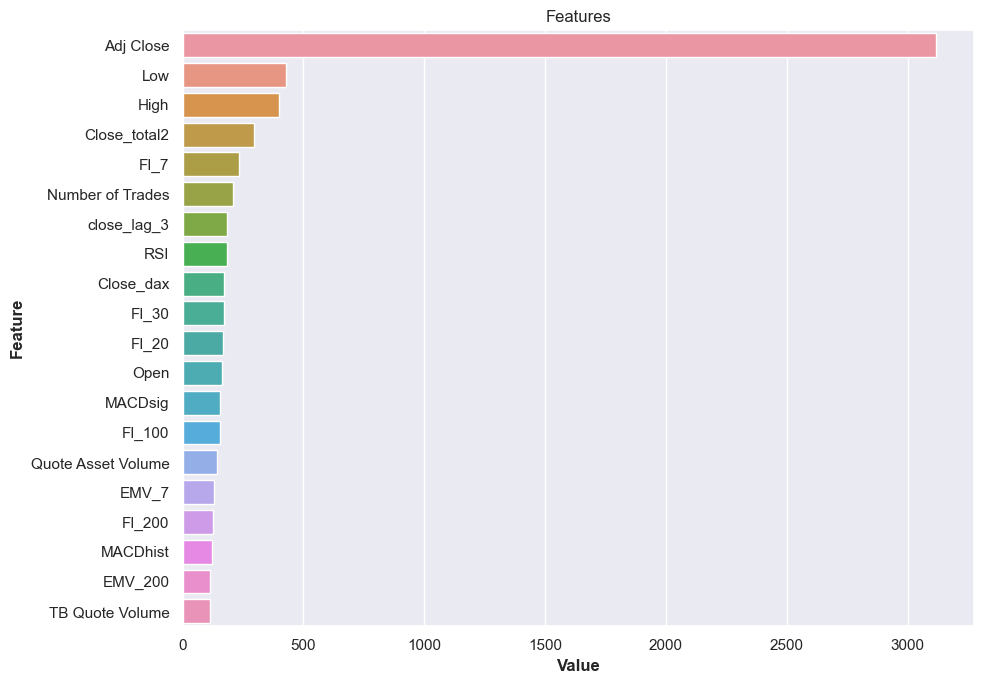

In [107]:
df_feat = plot_importance(lgbm_model, features=X_train, num=20)

In [109]:
df.to_csv("techcareer.csv")